# Uncertainty indicators for property fields

In the geosciences, uncertainty quantification relies on ensemble of models / realizations. 

The type of variables analysed can be viewed as:
 - Inputs for forward models (such as geomodelling, geophysical, hyrogeological, ... engines )
 - Model outputs
, which can be either of them e.g. density can be the output of a geo-modelling engine and an input for a geo-physical simulation.

Or they can also be depicted as:
 - Categorical: 
     - lithocode
     - any classification code  
 - Continuous: 
     - potential fields (from implicit modeling)
     - hydro-, geo-, petro-, physical- properties (e.g. porosity, hydraulic conductivity, density, mag, velocity, ...)

<div class="alert alert-block alert-warning">
    <b>Warning:</b> Indicators based on discrete or categorical variable require a standard classification for the realizations of the considered ensemble. Note that it is not the case for the 1 million noddyverse models, but we will ignore this fact, just to illustrate the computation of the indicators. 
</div>
    
Here, we focus on uncertainty quantification of property field and for the purpose of illustration we will use the following: 
 - 3D litho code
 - 3D density
 - 3D magnetic susceptipility
 - 2D gravity residuals
 - 2D magnetic residuals

Given an ensemble of property fields, there are two main ways to compute uncertainty indicators:
 - based on local cell comparison throughout the ensemble of realizations (e.g. Cardinality or Entropy) - note that it requires the same meshing for all realizations of the ensemble
 - using distances (Wasserstein, Jenson-Shannon, Fisher information metric ...) between summary statistics (e.g. semi-variogram, connectivity functions, MPH, topology indicators (matrices+....), persistent homology... that are computed for each realization) - in that case meshing might vary, and it enables the classification of realizations of an ensemble into clusters

One can note that cell-based uncertainty indicators will provide information about the local spatial variability of the property fields while distance-based ones will inform more about structural dis-similarity of the property fields.

# Dependencies
To run these notebooks:
% - noddyverse (available at https://github.com/Loop3D/noddyverse) 
 - numpy
 - pandas
 - urllib
 - gzip
 - matplotlib
 - datetime
 - pickle
 - seaborn
 - sklearn
 - scipy
 - pywt
 - mpl_toolkits
 

# Download property fields


In [1]:
# add the noddyverse folder locations to the path
# import sys
# sys.path.append("C:\\Users\\00102908\\utilities\\noddyverse-main\\")
# sys.path.append("C:\\Users\\00102908\\utilities\\noddyverse-main\\model_list\\")

# import modules
# from noddyverse import rand_cmap,get_gz_array
from uncertaintyIndicators import rand_cmap,get_gz_array
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import default_rng
from urllib.request import urlopen
import gzip
from datetime import datetime
import pickle
picklefilename = "./pickledata/testing-model-subset.pickle" # to save the downloaded data into existing folder
import os
if not os.path.exists('pickledata'):
    os.makedirs('pickledata')
    
# initialization
nbsamples = 10 # fixed for the demonstration of indicator computations
myseed=12345 # repeatable demo
cldurl = 'https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2f' # cloudstor url prefix
[nz,ny,nx]=[200,200,200]

rng = default_rng(myseed)
models=pd.read_csv('models.csv')
nbmodels = len(models)
models['cldurl'] = cldurl
models['url']= models['cldurl']+ models['event03']+'_'+ models['event04']+'_'+ models['event05']+'&files='+models['root'].str.rpartition('/')[2]

cmap = rand_cmap(100, type='bright', first_color_black=False, last_color_black=False, verbose=False)

mag_all = np.zeros((ny,nx,nbsamples))*np.nan
grv_all = np.zeros((ny,nx,nbsamples))*np.nan
mod_all = np.zeros((nz,ny,nx,nbsamples))*np.nan
sus_all = np.zeros((nz,ny,nx,nbsamples))*np.nan
rho_all = np.zeros((nz,ny,nx,nbsamples))*np.nan

# get random sample urls for data to dowanload
samples_ix=(np.round(np.random.uniform(0,1,nbsamples) * (nbmodels-1))). astype(int)
models.loc[samples_ix,'event_all']

906573                  FOLD FOLD FOLD
774062                  TILT PLUG TILT
333151                  DYKE FOLD TILT
81103     UNCONFORMITY FOLD SHEAR-ZONE
407249                 FOLD FAULT FOLD
232239                 TILT FAULT TILT
132490                FAULT FAULT PLUG
53428            FAULT SHEAR-ZONE FOLD
725608                 FAULT FOLD TILT
11428     UNCONFORMITY DYKE SHEAR-ZONE
Name: event_all, dtype: object

In [2]:
# For each sample
for s in range(nbsamples):
    root = models.loc[samples_ix[s],'url']
    display('loading '+root+' data.')
    # download gravity response
    path = root+'.grv.gz'
    grv_all[:,:,s] = get_gz_array(path,skiprows=8)
    # download magnetic response
    path = root+'.mag.gz'
    mag_all[:,:,s] = get_gz_array(path,skiprows=8)
    # download litho code model
    path = root + '.g12.gz'
    tmp = get_gz_array(path,skiprows=0).astype(int)
    mod = tmp.reshape((nz,nx,ny))
    mod = np.transpose(mod,(0,2,1))
    mod_all[:,:,:,s] = mod
    # download properties
    path = root + '.g00.gz'
    my_gzip_stream = urlopen(path)
    my_stream = gzip.open(my_gzip_stream, 'r')
    txt = my_stream.readlines()[417:]
    tmp = str(txt[0]).rsplit(' = ')[-1]
    nbrocks = int(tmp.rsplit('\\')[0])
    litho_cod = (np.zeros(nbrocks)).astype(int)
    litho_lab = [] #np.chararray(nbrocks)
    litho_rho = np.zeros(nbrocks)*np.nan
    litho_sus = np.zeros(nbrocks)*np.nan

    for r in range(nbrocks):
        pos = r*3
        tmp = str(txt[pos+1]).rsplit('ROCK DEFINITION ')[-1]
        lab = tmp.split(' = ')[0]
        cod = int((tmp.split(' = ')[1]).rsplit('\\')[0])
        tmp = str(txt[pos+2]).rsplit('Density = ')[-1]
        rho = float(tmp.rsplit('\\')[0])
        tmp = str(txt[pos+3]).rsplit('Sus = ')[-1]
        sus = float(tmp.rsplit('\\')[0])
        litho_cod[r] = cod
        litho_lab.append(lab)
        litho_rho[r] = rho
        litho_sus[r] = sus
        del cod,lab,rho,sus
       
    # assign density and magnetic susceptibility
    rho = np.zeros(mod.shape) * np.nan
    sus = np.zeros(mod.shape) * np.nan
    for r in range(nbrocks):
        ix = np.where(mod==litho_cod[r])
        rho[ix] = litho_rho[r]
        sus[ix] = litho_sus[r]    

    rho_all[:,:,:,s] = rho
    sus_all[:,:,:,s] = sus
    


'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fFOLD_FOLD_FOLD&files=20-09-13-11-43-12-006536815 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fTILT_PLUG_TILT&files=20-09-12-04-45-00-531746729 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fDYKE_FOLD_TILT&files=20-09-07-21-37-09-485948222 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fUNCONFORMITY_FOLD_SHEAR-ZONE&files=20-09-05-10-15-21-548997783 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fFOLD_FAULT_FOLD&files=20-09-08-14-58-43-040031132 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fTILT_FAULT_TILT&files=20-09-06-21-59-52-845439478 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fFAULT_FAULT_PLUG&files=20-09-05-22-29-22-544300093 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fFAULT_SHEAR-ZONE_FOLD&files=20-09-05-03-44-07-788671330 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fFAULT_FOLD_TILT&files=20-09-11-17-24-48-727158306 data.'

'loading https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fUNCONFORMITY_DYKE_SHEAR-ZONE&files=20-09-04-17-44-25-441892405 data.'

## Property field plots

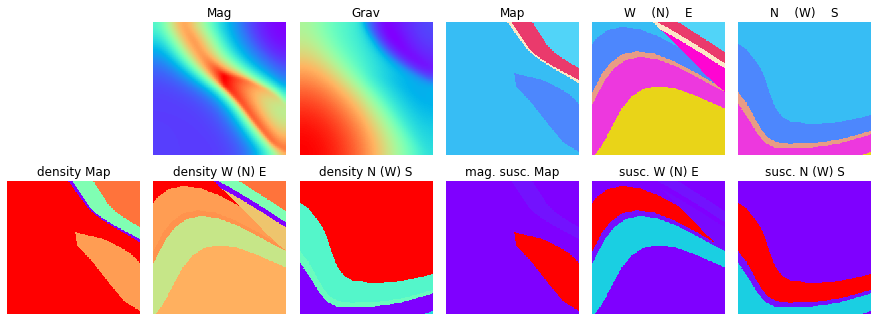

In [5]:
sample_num = 3 # a number < nb_samples
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"PLOT FOR SAMPLE #"+str(sample_num))
tmp_grv = grv_all[:,:,sample_num]
tmp_mag = mag_all[:,:,sample_num]
tmp_mod = mod_all[:,:,:,sample_num]
tmp_rho = rho_all[:,:,:,sample_num]
tmp_sus = sus_all[:,:,:,sample_num]
vmin = np.amin(tmp_mod)
vmax = np.amax(tmp_mod)

fig, ax = plt.subplots(2,6) #,figsize=(13,13)
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,2].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')
ax[0,5].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[1,2].axis('off')
ax[1,3].axis('off')
ax[1,4].axis('off')
ax[1,5].axis('off')
ax[0,1].set_title('Mag' ) #title.set_text
ax[0,2].set_title('Grav')
ax[0,3].set_title('Map')
ax[0,4].set_title('W    (N)    E')
ax[0,5].set_title('N    (W)    S')
ax[1,0].set_title('density Map')
ax[1,1].set_title('density W (N) E')
ax[1,2].set_title('density N (W) S')
ax[1,3].set_title('mag. susc. Map')
ax[1,4].set_title('susc. W (N) E')
ax[1,5].set_title('susc. N (W) S')
ax[0,1].imshow(tmp_mag,cmap='rainbow')
ax[0,2].imshow(tmp_grv,cmap='rainbow')
ax[0,3].imshow(tmp_mod[0,:,:],cmap=cmap, interpolation="nearest",vmin=vmin,vmax=vmax)
ax[0,4].imshow(tmp_mod[:,0,:],cmap=cmap, interpolation="nearest",vmin=vmin,vmax=vmax)
ax[0,5].imshow(tmp_mod[:,:,0],cmap=cmap, interpolation="nearest",vmin=vmin,vmax=vmax)
ax[1,0].imshow(tmp_rho[0,:,:],cmap='rainbow')
ax[1,1].imshow(tmp_rho[:,0,:],cmap='rainbow')
ax[1,2].imshow(tmp_rho[:,:,0],cmap='rainbow')
ax[1,3].imshow(tmp_sus[0,:,:],cmap='rainbow')
ax[1,4].imshow(tmp_sus[:,0,:],cmap='rainbow')
ax[1,5].imshow(tmp_sus[:,:,0],cmap='rainbow')
fig.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.05, wspace=0.1, hspace=0.1)
plt.show()


# Save downloaded data for indicator computations

In [ ]:
with open(picklefilename, 'wb') as f:
    pickle.dump([grv_all,mag_all,mod_all,rho_all,sus_all,cmap,samples_ix], f)



# Uncertainty voxets or maps
The indicator dimensions are the same as the property-field dimensions. 


## Cardinality (uncertainty voxet or map)
See [Cardinality notebook](./nbk-cardinality.ipynb)


## Entropy (uncertainty voxet or map)
See [Entropy notebook](./nbk-entropy.ipynb)


# Distance-based indicators
In that case, the dimensionality is proportional to the size of the ensemble. 

## Histogram
See [Histogram notebook](./nbk-hist.ipynb)

## Semi-variogram
See [Semi-variogram](./nbk-semivariogram.ipynb)


## Connectivity
See [Connectivity notebook](./nbk-connectivity.ipynb)


## Multiple-point histograms (MPH)
See [MPH notebook](./nbk-mph.ipynb)


## Wavelet decomposition
See [Wavelet notebook](./nbk-wavelet.ipynb)


## Topology
### Discrete case
in progress ...
### Continuous case
in progress ...

# Indicator comparison and visualization
See [Comparison plot notebook](./nbk-all-indicators-comparison.ipynb)